<a href="https://colab.research.google.com/github/eunzzae/Study_DL/blob/main/231111_%EC%8B%A4%EC%8A%B5_%5BPytorch%5DLSTM101_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- torch Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
seed = 2023
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [4]:
!pip install finance-datareader torchinfo

In [5]:
import FinanceDataReader as fdr

In [6]:
# 삼성전자(005930) 전체
index = '005930'
samsung = fdr.DataReader(index, start='19900101', end='20231231')
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-07-26,3120,3260,3060,3170,1212761,NaN
1999-07-27,3229,3399,3200,3370,910512,0.063091
1999-07-28,3409,3750,3390,3560,1952152,0.056380
1999-07-29,3699,3960,3570,3940,1661889,0.106742
1999-07-30,3939,4080,3740,3780,1945800,-0.040609
...,...,...,...,...,...,...
2023-11-06,69800,70900,69300,70900,22228489,0.018678
2023-11-07,70600,70900,70000,70900,17228731,0.000000
2023-11-08,71300,71400,69700,69900,12901310,-0.014104


매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [7]:
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-07-26,3120,3260,3060,3170,1212761,NaN
1999-07-27,3229,3399,3200,3370,910512,0.063091
1999-07-28,3409,3750,3390,3560,1952152,0.056380
1999-07-29,3699,3960,3570,3940,1661889,0.106742
1999-07-30,3939,4080,3740,3780,1945800,-0.040609
...,...,...,...,...,...,...
2023-11-06,69800,70900,69300,70900,22228489,0.018678
2023-11-07,70600,70900,70000,70900,17228731,0.000000
2023-11-08,71300,71400,69700,69900,12901310,-0.014104


## 시각화

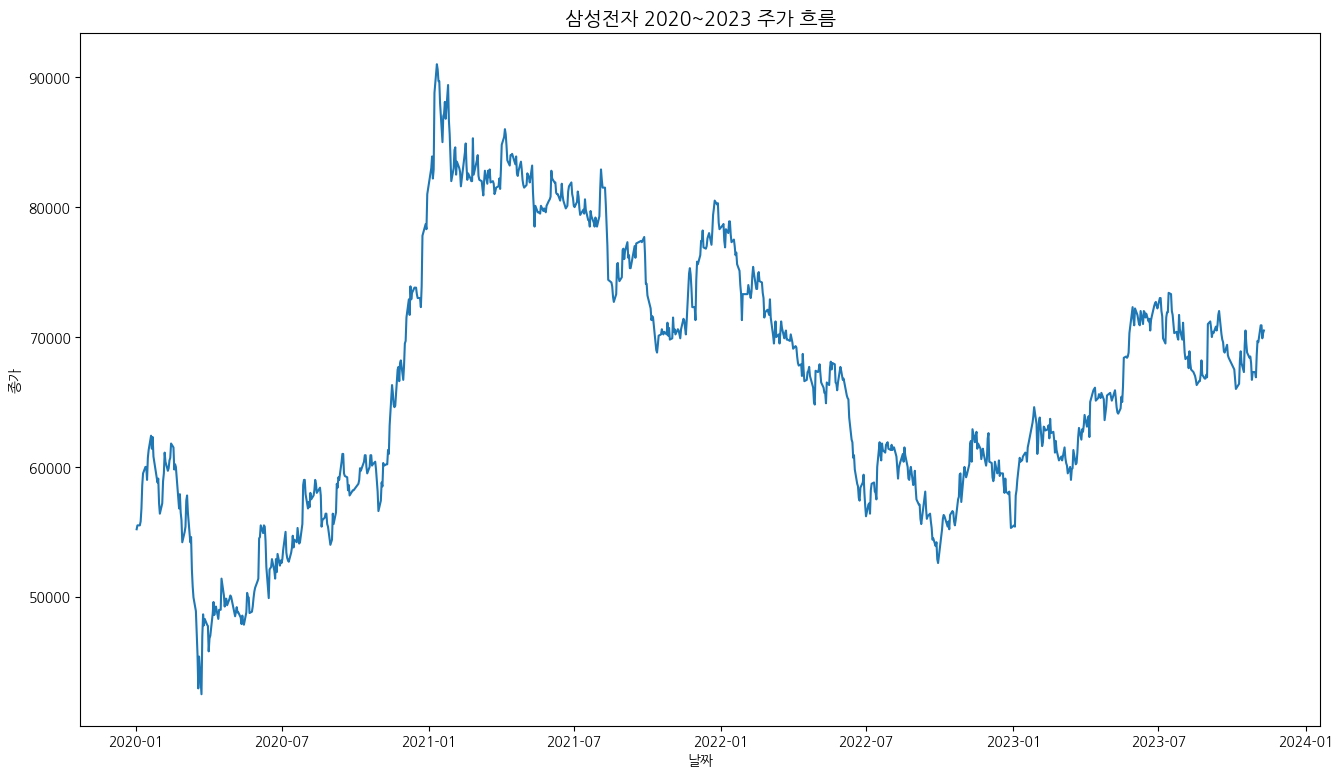

In [10]:
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(16, 9))
plt.title('삼성전자 2020~2023 주가 흐름', fontsize=14)
sns.lineplot(data=samsung.loc[samsung.index > '20200101'], x='Date', y="Close")
plt.xlabel('날짜')
plt.ylabel('종가')
plt.show()

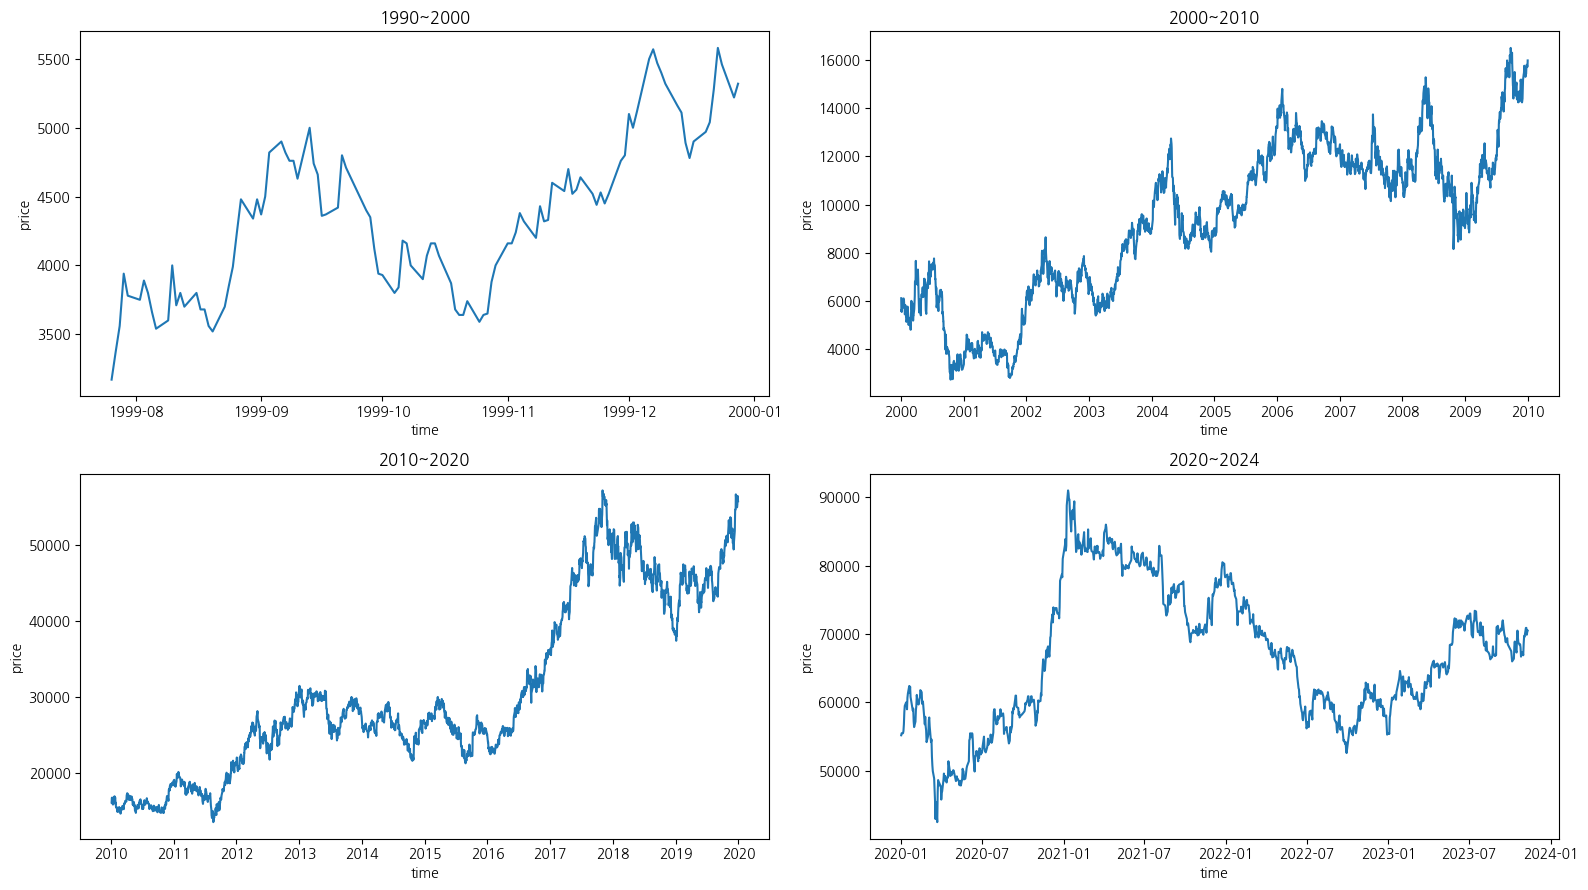

In [13]:
time_steps = [['1990', '2000'],
              ['2000', '2010'],
              ['2010', '2020'],
              ['2020', '2024']] # COVID-19

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = samsung.loc[(samsung.index > time_steps[i][0]) & (samsung.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Volume', 'Close']
# 스케일 후 columns

df = samsung.loc[samsung.index > '20200101', scale_cols]
scaled = scaler.fit_transform(df)
scaled

array([[0.27044025, 0.23380282, 0.2690678 , 0.0854681 , 0.26185567],
       [0.28092243, 0.24507042, 0.26694915, 0.11420097, 0.26804124],
       [0.25786164, 0.22629108, 0.26059322, 0.05336102, 0.26804124],
       ...,
       [0.60167715, 0.52300469, 0.58050847, 0.08438081, 0.56494845],
       [0.57232704, 0.51173709, 0.57838983, 0.07728418, 0.57319588],
       [0.57442348, 0.50610329, 0.57627119, 0.03927001, 0.57731959]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [16]:
df = pd.DataFrame(scaled, columns=scale_cols, index=df.index)
df

,Open,High,Low,Volume,Close
Date,,,,,
2020-01-02,0.270440,0.233803,0.269068,0.085468,0.261856
2020-01-03,0.280922,0.245070,0.266949,0.114201,0.268041
2020-01-06,0.257862,0.226291,0.260593,0.053361,0.268041
2020-01-07,0.274633,0.241315,0.281780,0.050177,0.274227
2020-01-08,0.285115,0.260094,0.288136,0.209766,0.294845
...,...,...,...,...,...
2023-11-06,0.570231,0.513615,0.572034,0.194712,0.585567
2023-11-07,0.587002,0.513615,0.586864,0.135570,0.585567
2023-11-08,0.601677,0.523005,0.580508,0.084381,0.564948


## train / test 분할

- 2021년 이전까지의 모든 데이터로, 2022년을 예측해봅니다.


- 시계열 예측에서는 "예측 당시"에는 미래의 데이터를 모릅니다. 그래서 train 데이터는 무조건 test 데이터보다 시기적으로 **과거**여야합니다.

In [17]:
train = df.loc[df.index < '20230101']
X_train, y_train = train.drop("Close", axis=1), train.Close
test = df.loc[df.index > '20230101']
X_test, y_test = test.drop("Close", axis=1), test.Close

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(742, 4) (742,) (212, 4) (212,)


In [18]:
X_train

,Open,High,Low,Volume
Date,,,,
2020-01-02,0.270440,0.233803,0.269068,0.085468
2020-01-03,0.280922,0.245070,0.266949,0.114201
2020-01-06,0.257862,0.226291,0.260593,0.053361
2020-01-07,0.274633,0.241315,0.281780,0.050177
2020-01-08,0.285115,0.260094,0.288136,0.209766
...,...,...,...,...
2022-12-23,0.327044,0.278873,0.326271,0.048043
2022-12-26,0.322851,0.273239,0.326271,0.011693
2022-12-27,0.322851,0.278873,0.330508,0.057952


In [19]:
y_test

Date
2023-01-02    0.268041
2023-01-03    0.265979
2023-01-04    0.315464
2023-01-05    0.323711
2023-01-06    0.340206
                ...   
2023-11-06    0.585567
2023-11-07    0.585567
2023-11-08    0.564948
2023-11-09    0.573196
2023-11-10    0.577320
Name: Close, Length: 212, dtype: float64

## Data Preparation

In [26]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

seq_length = 30
batch_size = 32

# 데이터셋 생성 함수
def build_dataset(X, y, seq_length):

    X_data = []
    y_data = []

    for idx in range(0, len(X)-seq_length):
      # idx = 0 ~ len(X)-seq_length-1
        _X = X[idx:idx+seq_length] # 30개 feature vectors
        _y = y[idx+seq_length]  # 1개 (31번쨰 target value, close)
        # print(_X, '--->', _y)
        X_data.append(_X.values)
        y_data.append(_y)

    X_data = torch.FloatTensor(np.array(X_data))
    y_data = torch.FloatTensor(np.array(y_data))

    return X_data, y_data

trainX, trainY = build_dataset(X_train, y_train, seq_length)
testX, testY = build_dataset(X_test, y_test, seq_length)

# 텐서로 변환

# 텐서 형태로 데이터 정의
trainset = TensorDataset(trainX, trainY)
testset = TensorDataset(testX, testY)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
trainloader = DataLoader(trainset,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)
testloader = DataLoader(testset,
                         batch_size=batch_size,
                         shuffle=False,
                         drop_last=True)

## Define Model

In [32]:
class LSTM(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, n_layers):
        super().__init__()
        self.input_dim = input_dim     # input feature vector dim
        self.hidden_dim = hidden_dim   # hidden layer node 개수 (= hidden state dim)
        self.seq_len = seq_len         # hidden state 개수 (= input sequence length)
        self.output_dim = output_dim   # output layer의 node 개수 (=output dim)
        self.n_layers = n_layers       # multi-layer로 구성할 때, (hidden, LSTM)layer 수

        self.lstm = nn.LSTM(input_size=input_dim,     # Wxh (input_dim x hidden_dim)
                            hidden_size=hidden_dim,   # Whh (hidden_dim x hidden_dim)
                            num_layers=n_layers,
                            batch_first=True,
                            dropout=0.1,    # hidden layer의 node중에 일부를 deactivate 시킴.
                            bidirectional=False)

        self.fc = nn.Linear(in_features=hidden_dim,
                            out_features=output_dim)  # Why

    # 예측을 위한 함수
    def forward(self, x, (h0, c0)): # (N, L H_in)
        # (n_layers, batch_size, hidden_dim)
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim)
        # input : (x, (h0, c0))
        # output : (x, (hn, cn))
        x, (hn, cn) = self.lstm(x, (h0, c0)) # (N, L, H_in) -- (LSTM) --> (N, L, H_out)
        # e.g. (batch_size, seq_len, hidden_dim)
        ## 마지막 출력 결과(last_hidden_state) --> (batch_size, hidden_dim)
        # e.g. (32, 30, 4) --> (32, 30, 10)
        ## 마지막 출력결과(last_hidden_state) --> (32, 10)
        x = self.fc(x[:, -1, :]) # (batch_size, hidden_dim) --> (batch_size, outpu_dim) # (32, 10) ==> (32, 1) ## weighted sum ==> Linear Regression
        return x, (hn, cn)

        # h0 = zero vec
        # c0 = zero vec
        # # input : (x, (h0, c0))
        # # output : (x, (hn, cn))

        # x, (hn, cn) = self.lstm(x, (h0, c0))
        # x = self.fc(last hidden state)

        # return x, (hn, cn)

SyntaxError: ignored

In [33]:
tX, ty = next(iter(trainloader))
tX.shape, ty.shape # (batch_size, seq_len, input_dim) ## (N, L, H_in)

(torch.Size([32, 30, 4]), torch.Size([32]))

In [31]:
# rnn = nn.LSTM(10, 20, 2) # (L, N, H_in)
model = LSTM(input_dim=4,
             hidden_dim=10,
             seq_len=30,
             output_dim=1,
             n_layers=1)
# input = torch.randn(5, 3, 10) # (L, N, H_in)
h0 = torch.randn(1, batch_size, 10) # (n_layers, batch_size, hidden_dim)
c0 = torch.randn(1, batch_size, 10)
output, (hn, cn) = model(tX, (h0, c0))
print(output.shape, hn.shape, cn.shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


TypeError: ignored

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# 설정값
input_dim =
hidden_dim =
output_dim =
learning_rate =
n_epochs =
n_layers =

In [ ]:
# define model
model =
model

In [ ]:
criterion =
optimizer =

In [ ]:
def train_model(model, train_df, n_epochs = None, lr = None, verbose = 10, patience = 10):

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

    return model, train_hist

In [ ]:
# 모델 학습
model, train_hist =

In [ ]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

## 예측 데이터 시각화

In [ ]:
# 예측 테스트


avg_loss = avg_loss / len(testloader)
print("Test MSE : %.4f" % avg_loss)

In [ ]:
plot_data = [pred + label for pred, label in zip(preds, labels)]
plot_data